### Clustering Mouse model parameters from hall-of-fame 

In [260]:
%matplotlib inline

from ateamopt.analysis.optim_analysis import Optim_Analyzer
import glob
import json
import pandas as pd
import multiprocessing
from multiprocessing import Pool
from functools import partial
import os
from ateamopt.utils import utility
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler   
from sklearn.pipeline import Pipeline 
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
from collections import defaultdict

In [261]:
# Setting the path for data
mouse_param_path = '/allen/aibs/mat/ateam_shared/Mouse_Model_Fit_Metrics/*/fitted_params/hof_param*.json'
cell_metadata_dir = '/allen/aibs/mat/ateam_shared/Mouse_Model_Fit_Metrics'
param_file_list = glob.glob(mouse_param_path)

# param_files are of the format 'hof_param_cellid_hof_index.json'
cell_id_list = [param_file_path.split('_')[-2].split('.')[0] for param_file_path in param_file_list] 
hof_index_list = [param_file_path.split('_')[-1].split('.')[0] for param_file_path in param_file_list] 

metadata_path_pattern = cell_metadata_dir + '/%s/cell_metadata_%s.json'
sample_metadata_path = metadata_path_pattern%(cell_id_list[0],cell_id_list[0])
sample_metadata = utility.load_json(sample_metadata_path)
metadata_fields = list(sample_metadata.keys())
metadata_fields += 'hof_index'

In [262]:
analysis_handler = Optim_Analyzer()
repeat_params = ['Ra', 'e_pas', 'g_pas'] # Reduce param space by removing identical parameters
func = partial(analysis_handler.convert_aibs_param_to_dict, repeat_params = repeat_params)

p = Pool(multiprocessing.cpu_count())
param_dict_list = p.map(func,param_file_list)
p.close()
p.join()


In [263]:
# Add metadata and hof_index to the parameter dictionary

def add_cell_metadata(param_dict,cell_id,metadata_path_pattern,hof_index = 0):
    metadata_path = metadata_path_pattern%(cell_id,cell_id)
    cell_metadata = utility.load_json(metadata_path)
    for key,val in cell_metadata.items():
        param_dict[key] = val
        
    param_dict['hof_index'] = int(hof_index)
    return param_dict


param_df_list = [add_cell_metadata(param_dict,cell_id,metadata_path_pattern,hof_index) \
                 for param_dict,cell_id,hof_index in zip(param_dict_list,cell_id_list,hof_index_list)]
param_df = pd.DataFrame(param_df_list)


In [264]:
# Filtering data according to specification

def filter_df(param_df, **filter_obj):
    for filter_key,filter_val in filter_obj.items():
        param_df = param_df.loc[param_df[filter_key] == filter_val,]
        param_df.drop(filter_key, axis = 1, inplace = True)    
    
    return param_df

filter_dict_spiny = {'Dendrite_type' : 'spiny'}
param_df_filtered_spiny = filter_df(param_df, **filter_dict_spiny)
param_df_filtered_spiny = param_df_filtered_spiny.dropna(axis=1, how = 'all')

filter_dict_aspiny = {'Dendrite_type' : 'aspiny'}
param_df_filtered_aspiny = filter_df(param_df, **filter_dict_aspiny)
param_df_filtered_aspiny = param_df_filtered_aspiny.dropna(axis=1, how = 'all')


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [265]:
# PCA

def pca_2D(param_df, metadata_fields, figname = None, drop_apical = False):  
    
    pca_pipeline = Pipeline([('scaling', StandardScaler()), \
                             ('pca', PCA(n_components=2))])
        
    # Get the conductance parameters
    
    param_df_conductance = param_df.loc[:,[col_var for col_var in \
                      list(param_df.columns.values) if col_var not in metadata_fields]]
    if drop_apical:
        cols = [c for c in param_df_conductance.columns if 'apic' not in c]
        param_df_conductance = param_df_conductance[cols]
    
    X_cond = param_df_conductance.values
    pca_result = pca_pipeline.fit_transform(X_cond)
    
    pca_step = pca_pipeline.named_steps['pca']
    
    param_df_pca = param_df.copy()
    param_df_pca['pca-one'] = pca_result[:,0]
    param_df_pca['pca-two'] = pca_result[:,1] 
    
    sns.set(style="darkgrid", font_scale=1)
    g = sns.FacetGrid(param_df_pca, col="Layer",col_order =['2/3', '4', '5'], 
                      hue="Cre_line",height=6, aspect=.7)
    g = (g.map(plt.scatter, "pca-one", "pca-two", alpha=.8).add_legend())
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(figname)
    plt.show()
    

# TSNE
    
def tsne_embedding(param_df,metadata_fields, figname = None, drop_apical = False):
    
    # Get the conductance parameters
    
    param_df_conductance = param_df.loc[:,[col_var for col_var in \
                      list(param_df.columns.values) if col_var not in metadata_fields]]
    
    if drop_apical:
        cols = [c for c in param_df_conductance.columns if 'apic' not in c]
        param_df_conductance = param_df_conductance[cols]
    
    X_cond = param_df_conductance.values
    tsne_pipeline = Pipeline([('scaling', StandardScaler()), \
                             ('tsne',TSNE(n_components=2,random_state =1))])
    
    tsne_results = tsne_pipeline.fit_transform(X_cond)
    param_df_tsne = param_df.copy()
    param_df_tsne['x-tsne'] = tsne_results[:,0]
    param_df_tsne['y-tsne'] = tsne_results[:,1]
    
    sns.set(style="darkgrid", font_scale=1)
    g = sns.FacetGrid(param_df_tsne, col="Layer",col_order =['2/3', '4', '5'], 
                      hue="Cre_line",height=6, aspect=.7)
    g = (g.map(plt.scatter, "x-tsne", "y-tsne", alpha=.8).add_legend())
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(figname)
    plt.show()

#### Analysis for spiny and aspiny cells 

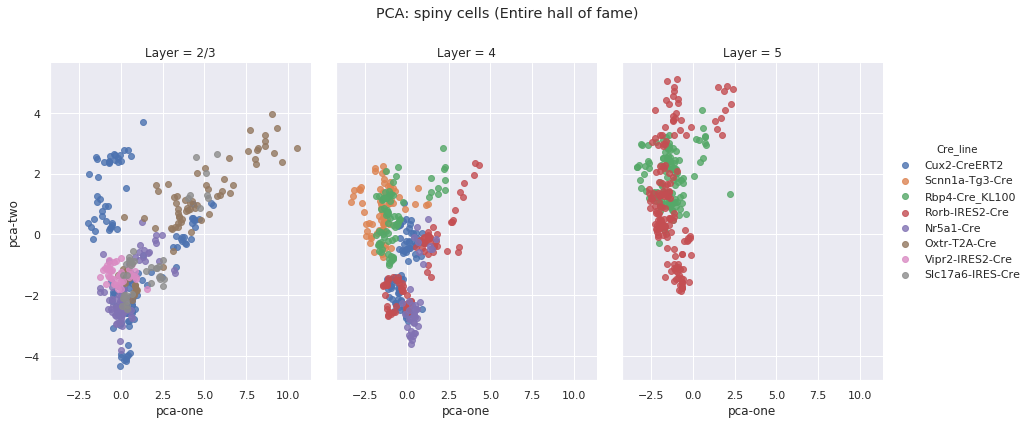

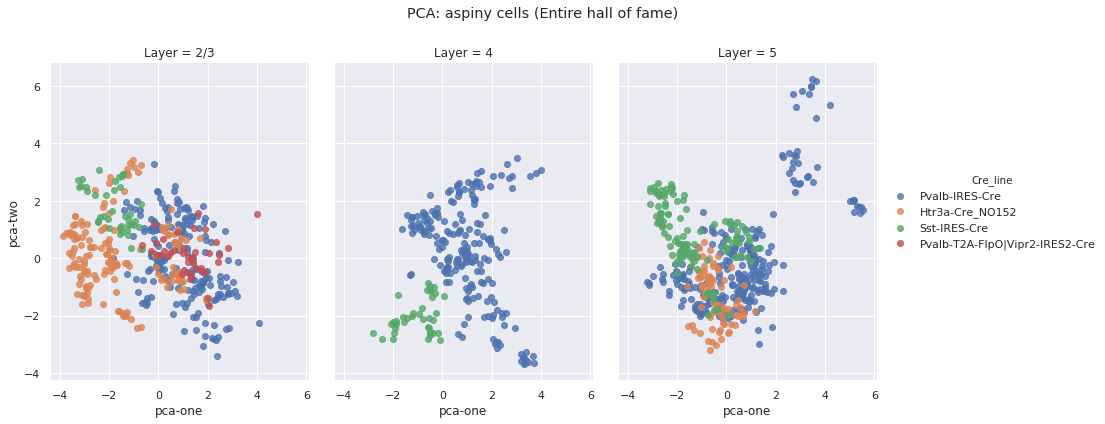

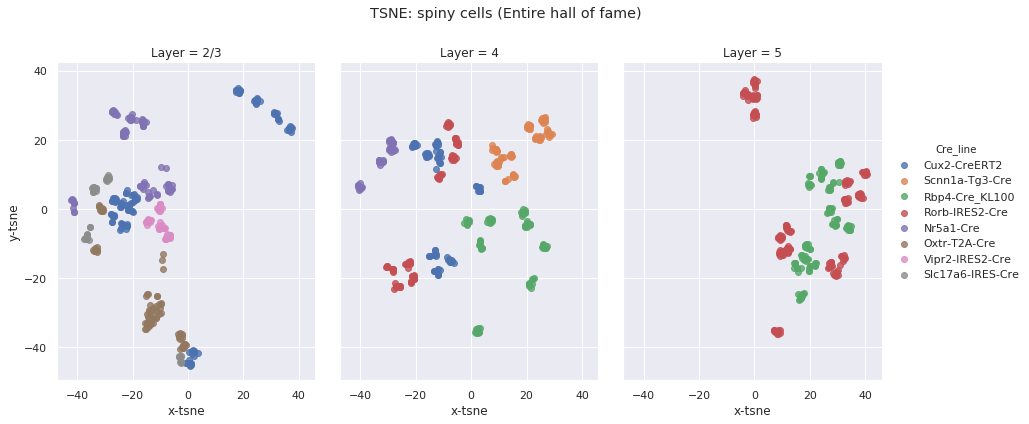

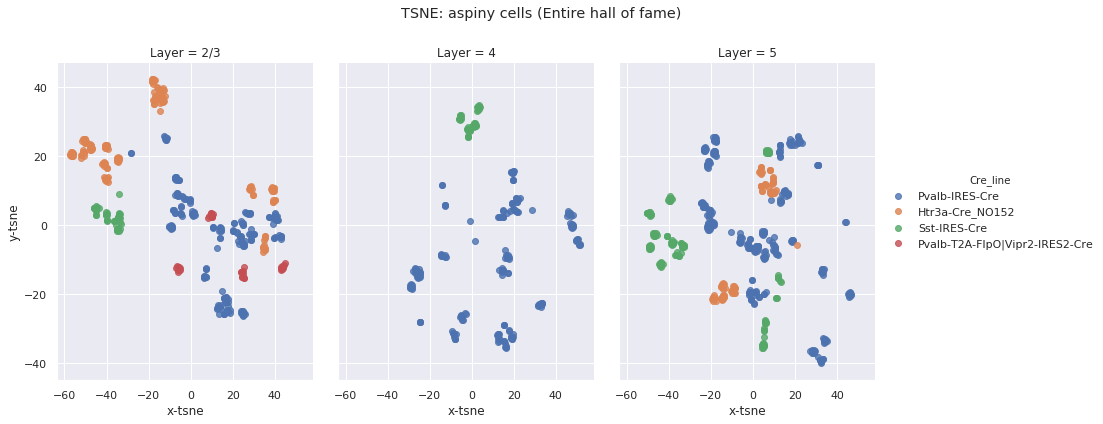

In [266]:
# Pca
pca_2D(param_df_filtered_spiny, metadata_fields, figname = 'PCA: spiny cells (Entire hall of fame)')
pca_2D(param_df_filtered_aspiny, metadata_fields, figname = 'PCA: aspiny cells (Entire hall of fame)',drop_apical = True)

# Tsne
tsne_embedding(param_df_filtered_spiny,metadata_fields,figname = 'TSNE: spiny cells (Entire hall of fame)')
tsne_embedding(param_df_filtered_aspiny,metadata_fields,figname = 'TSNE: aspiny cells (Entire hall of fame)',drop_apical = True)


### Selecting hall of fame models based on tolerance around best Cre-line specific performers 

In [267]:
mouse_metrics_path = '/allen/aibs/mat/ateam_shared/Mouse_Model_Fit_Metrics/'
optimization_metric_file = 'exp_variance_hof.pkl'
cwd = os.getcwd()

# Aggregate the evaluation metrics

metric_files = []
metadata_files = []
df_list = []
df_metric_stacked = []

for subdir, dirs, files in os.walk(mouse_metrics_path):
    if optimization_metric_file in files:
        for file_ in files:
            filepath =  os.path.join(subdir, file_)
            if file_.endswith('.json'):
                metadata_files.append(filepath)
            elif file_ == optimization_metric_file:
                metric_files.append(filepath)
                
for metric_file_,metadata_file_ in zip(metric_files,metadata_files):
    df_list_expanded = []
    
    # Workaround for python3 (incompatibility between pickle objects between python 2 and 3)
    with open(metric_file_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        metric_list = u.load()
    metric_dict = [{'hof_index' : ii, 'Feature_Avg_Train' : metric_list_['Feature_Average'],
                   'Feature_Avg_Generalization' : metric_list_['Feature_Average_Generalization'],
                   'Explained_Variance' : metric_list_['Explained_Variance']} \
                   for ii,metric_list_ in enumerate(metric_list)]
    
    for ii, metric_list_ in enumerate(metric_list):
        for key_,val_ in metric_list_.items():
            if key_ in ['Feature_Average', 'Feature_Average_Generalization', 'Explained_Variance']:
                df_list_expanded.append({'hof_index': ii, 'Eval_Metric_Name' : key_,
                                     'Eval_Metric_Val' : val_})
    
    df_metric = pd.DataFrame(metric_dict)
    df_metric_expanded = pd.DataFrame(df_list_expanded)
    metadata = json.load(open(metadata_file_))
    for meta_key, meta_val in metadata.items():
        df_metric[meta_key] = meta_val
        df_metric_expanded[meta_key] = meta_val
    df_list.append(df_metric.copy())
    df_metric_stacked.append(df_metric_expanded.copy())

    
df_metrics_total = pd.concat(df_list,ignore_index=True)
df_metrics_long = pd.concat(df_metric_stacked, ignore_index = True)

df_metrics_total['Explained_Variance'] *= 100
mask = (df_metrics_long.Eval_Metric_Name == 'Explained_Variance')
df_metrics_long.loc[mask, 'Eval_Metric_Val'] *= 100 

In [275]:
# Get selected models based on tolerance values

cre_lines = list(set(df_metrics_total['Cre_line'].values))
tol_list = np.arange(0,1.1,.1)
tol_dict = {}

df_metrics_best = df_metrics_total.loc[df_metrics_total.hof_index == 0,]
cre_grouped = df_metrics_best.groupby('Cre_line')
cre_grouped_metrics = cre_grouped['Feature_Avg_Train'].agg(np.mean)

for tol in tol_list:
    tol_dict[tol] = {}
    for cre in cre_lines:
        fa_tol = cre_grouped_metrics[cre] + tol*cre_grouped_metrics[cre]
        df_metrics_tol = df_metrics_total.loc[df_metrics_total.Feature_Avg_Train <= fa_tol,['Cell_id','hof_index']]
        for cell in df_metrics_tol.Cell_id.values:
            tol_dict[tol][cell] = df_metrics_tol.loc[df_metrics_tol.Cell_id == cell,\
                    'hof_index'].values.tolist()
            

In [279]:
print(cre_grouped_metrics)

Cre_line
Cux2-CreERT2                      1.892544
Htr3a-Cre_NO152                   2.250452
Nr5a1-Cre                         1.013930
Oxtr-T2A-Cre                      5.133247
Pvalb-IRES-Cre                    2.147823
Pvalb-T2A-FlpO|Vipr2-IRES2-Cre    2.310012
Rbp4-Cre_KL100                    1.373586
Rorb-IRES2-Cre                    1.192512
Scnn1a-Tg3-Cre                    1.369716
Slc17a6-IRES-Cre                  1.010922
Sst-IRES-Cre                      1.035082
Vipr2-IRES2-Cre                   0.856700
Name: Feature_Avg_Train, dtype: float64


/allen/aibs/mat/ateam_shared/optimization_software/conda/ateam_opt/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


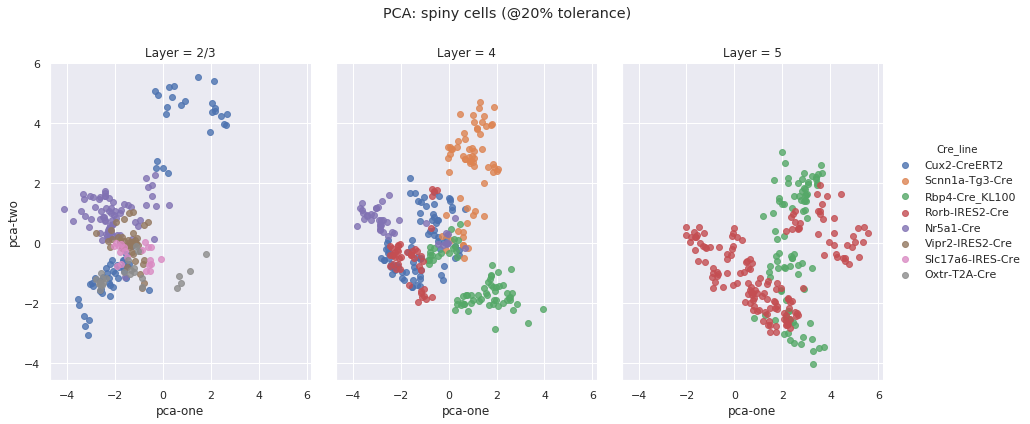

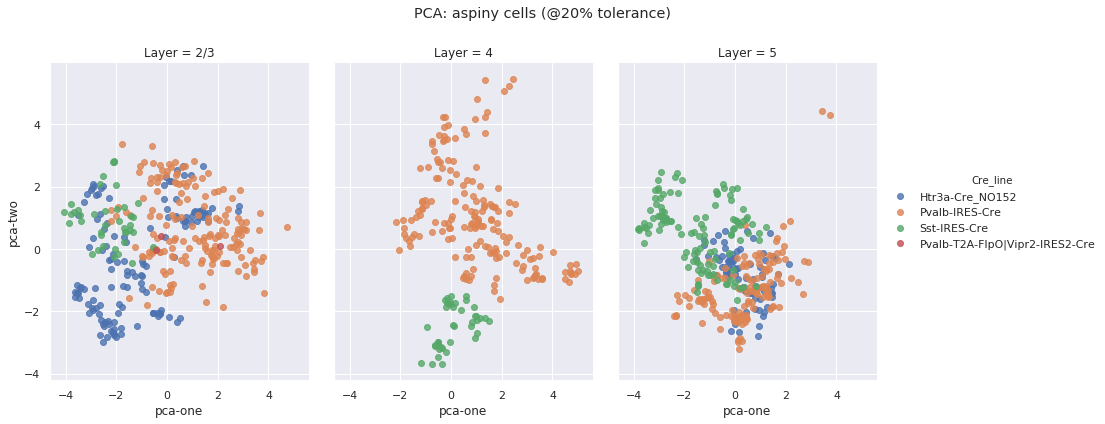

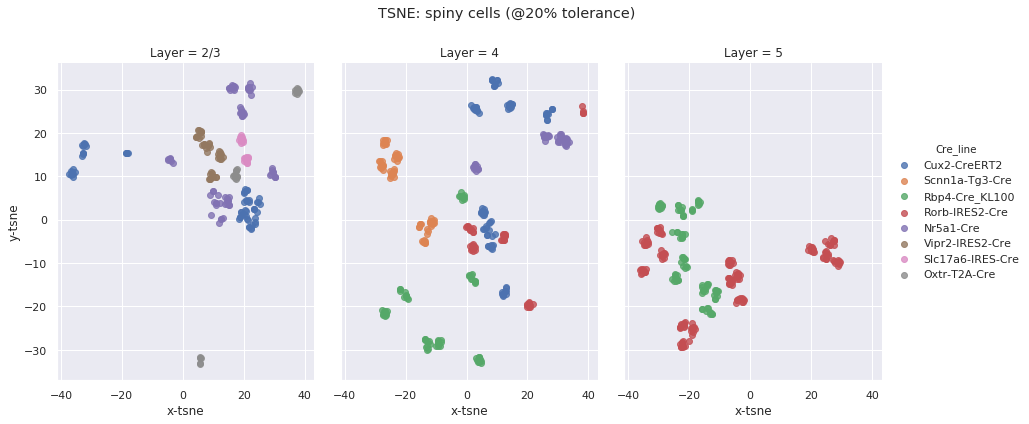

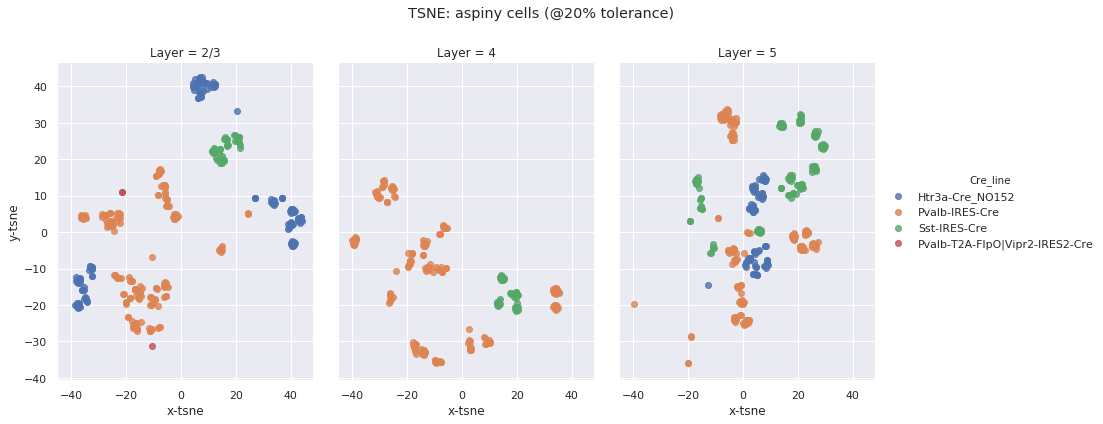

In [277]:
param_filtered_list = []

for cell_id,hof_list in tol_dict[0.2].items():
    param_filtered_list.append(param_df.loc[(param_df.Cell_id == cell_id) & (param_df.hof_index <= max(hof_list)),])
    
param_tol_df = pd.concat(param_filtered_list)
param_tol_df_spiny = filter_df(param_tol_df, **filter_dict_spiny)
param_tol_df_spiny = param_tol_df_spiny.dropna(axis=1, how = 'all')

param_tol_df_aspiny = filter_df(param_tol_df, **filter_dict_aspiny)
param_tol_df_aspiny = param_tol_df_aspiny.dropna(axis=1, how = 'all')

# PCA
pca_2D(param_tol_df_spiny, metadata_fields, figname = 'PCA: spiny cells (@20% tolerance)')
pca_2D(param_tol_df_aspiny, metadata_fields, figname = 'PCA: aspiny cells (@20% tolerance)',drop_apical = True)

# TSNE
tsne_embedding(param_tol_df_spiny,metadata_fields,figname = 'TSNE: spiny cells (@20% tolerance)')
tsne_embedding(param_tol_df_aspiny,metadata_fields,figname = 'TSNE: aspiny cells (@20% tolerance)',drop_apical = True)


In [278]:
len(param_tol_df)

1667